# Extraction of the overall trajectory of a single spot.

Extract_trajectory function uses the previous machine learning model (ridge) to predict the spot location in a frame and returns the trajectory of a the chosen spot (spot_number) from the initial frame. There were 8 spots detected in this movie in total.

In [104]:
def extract_trajectory(spot_number):   
    spots_first_frame = peak_local_max(wave2[:,:,0],min_distance = 2, threshold_abs = np.mean(wave1[:,:,0]) + 1.5*np.std(wave1[:,:,0]), exclude_border = 10)

    tracking = np.zeros((frames,2),int) #to track the pixel location of the spot as an integer
    trajectory = np.zeros((frames,2),float) #to track the exact location of the spot
    tracking[0] = spots_first_frame[spot_number]
    im_size = 4

    for i in range(frames):
        center_detection = wave2[tracking[i,0]-im_size:tracking[i,0]+im_size+1,tracking[i,1]-im_size:tracking[i,1]+im_size+1,i]

        center_detection = (center_detection - np.mean(center_detection)) / np.std(center_detection)

        trajectory[i] = ridge.predict(center_detection.reshape(1, 81))
        trajectory[i,0] = tracking[i,0] + trajectory[i,0] - im_size #update the coordinates
        trajectory[i,1] = tracking[i,1] + trajectory[i,1] - im_size

        if i == frames - 1:
            break
        else:
            tracking[i+1] = np.round(trajectory[i]) #update the next tracking pixel location to use as ref. in next loop

    return trajectory

    
    


In [283]:
trajectory = extract_trajectory(0) #extract the trajectory of the first spot during 100 frames.

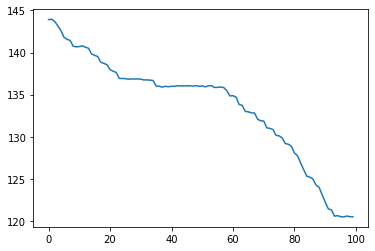

In [284]:
trajectory = pd.DataFrame(trajectory)
plt.plot(np.sqrt(trajectory[1]**2 + trajectory[0]**2))

# Detection of step location by investigating the overall trace.

I can visualize the steps on the trajectory clearly, I will plot the centers as a scatter plot and use a datacursor to select the locations of the steps by hand (and create a flag of 1 in those locations), this is necessary to train the algorithm.

/Users/enescaglar/anaconda3/lib/python3.7/site-packages/mpldatacursor/convenience.py:160: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cbook.iterable(axes):
/Users/enescaglar/anaconda3/lib/python3.7/site-packages/mpldatacursor/datacursor.py:140: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cbook.iterable(artists):


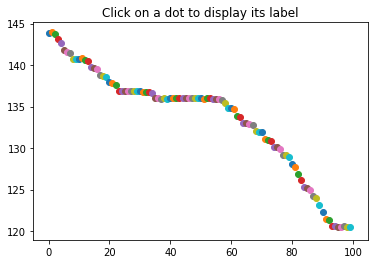

In [285]:
import matplotlib.pyplot as plt
from mpldatacursor import datacursor
import random

fig, ax = plt.subplots()
ax.set_title('Click on a dot to display its label')

for index,rows in trajectory.iterrows():
    ax.scatter([index], [np.sqrt(trajectory[1].loc[index]**2 + trajectory[0].loc[index]**2)], label='$ID: {}$'.format(rows))
# Use a DataCursor to interactively display the label.
datacursor(formatter='{label}'.format)

plt.show()

In [286]:
step_alerts = [6,9,15,18,21,24,36,60,63,65,69,72,75,78,81,85,88,92,94] #frame numbers where the protein steps takes a step.

On the position versus time plot above, I decided where the steps are by investigating with eye. The idea is that once I have enough data of where the flags for the steps are supposed to be, I can train a Machine Learning Algorithm to automatically detect the steps. Below, I am plotting the trajectory with the step size fits, dynein takes 8 nm steps but its stepping pattern is highly irregular. Furthermore, dwell times; time that passes between two consecutive steps, can also be extracted from the data. 
<br><br>Dwell time distribution is a important metric for the analysis of the stepping patterns of motor proteins in general. There are also recently published papers from our lab demonstrating/analyzing how the dwell time distribution is affacted by the presence of different types of obstacles [DeWitt et al.](https://docs.wixstatic.com/ugd/6d9b43_4cccd74299b149889b51ec5ed8a35dc4.pdf), Important analysis on the run leghts of motor proteins in the presence of obstacles by [Ferro et al.](https://elifesciences.org/articles/48629)<br><br>
I am plotting the steps in different colors to better visualize them.

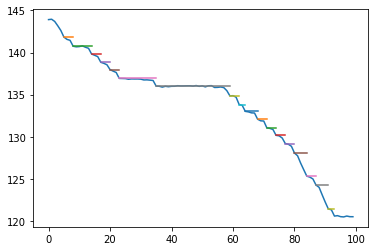

In [52]:
overall_position = np.sqrt(trajectory[1]**2 + trajectory[0]**2)
plt.plot(overall_position)
step_sizes = []
dwell_times =[]

for i in range(len(step_alerts)-1):
    x = [step_alerts[i]-1,step_alerts[i+1]-1]
    position = np.sqrt(trajectory.loc[step_alerts[i]-1][0]**2 + trajectory.loc[step_alerts[i]-1][1]**2)
    y = [position, position]
    dwell_times = np.append(dwell_times,-step_alerts[i]+step_alerts[i+1])
    if i !=0:
        step_sizes = np.append(step_sizes,temp-position)
    temp = position
    plt.plot(x,y)

In the next notebook, I will create features relevant to detect where the steps occur and feed these features into a Classification model to detect the steps.